# MP 1 : Classification, wieght sharing, auxiliary losses

In [136]:
import torch
from torch import nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import random 

from dlc_pratical_prologue import generate_pair_sets

## The data

Train set size = Test size = 1000

In [137]:
N = 1000
train_input, train_target, train_classes, test_input, test_target, test_classes = generate_pair_sets(N)

In [138]:
inp = train_input[0]

In [139]:
train_input.shape, train_target.shape, train_classes.shape

(torch.Size([1000, 2, 14, 14]), torch.Size([1000]), torch.Size([1000, 2]))

In [140]:
test_input.shape, test_target.shape, test_classes.shape

(torch.Size([1000, 2, 14, 14]), torch.Size([1000]), torch.Size([1000, 2]))

#### The images

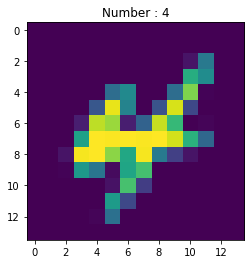

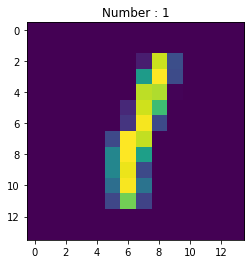

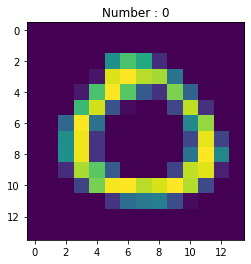

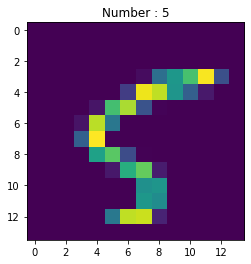

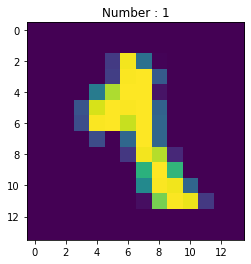

<Figure size 432x288 with 0 Axes>

In [141]:
for i in range(5):
    index = random.randint(0, 1000)
    plt.imshow(train_input[index][0])
    plt.title("Number : {0}".format(train_classes[index][0]))
    plt.figure()

#### Class balance

In [142]:
#Train
num_ones = train_target.sum()
num_zeros = N - num_ones
num_zeros, num_ones

(tensor(424), tensor(576))

In [143]:
#Test
num_ones = test_target.sum()
num_zeros = N - num_ones
num_zeros, num_ones

(tensor(439), tensor(561))

(array([196., 231., 201., 202., 187., 182., 206., 212., 183., 200.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

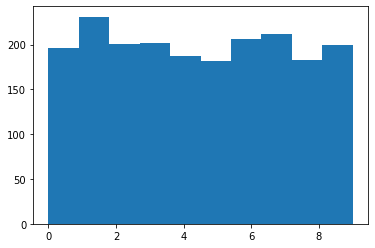

In [144]:
plt.hist(train_classes.reshape(2000))

(array([184., 220., 202., 198., 208., 161., 191., 229., 182., 225.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

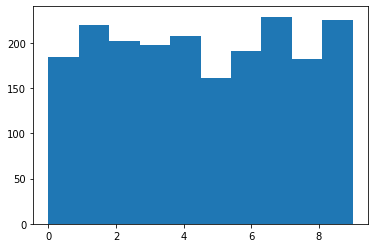

In [145]:
plt.hist(test_classes.reshape(2000))

Balance classes ? 

## The model
### Shape

- Input (2x14x14):2 14x14 greyscale images
- Output (1x1): one class (0 or 1)
- Layers?

#### Model structure
- LeNet5: https://www.datasciencecentral.com/profiles/blogs/lenet-5-a-classic-cnn-architecture#:~:text=The%20LeNet%2D5%20architecture%20consists,and%20finally%20a%20softmax%20classifier.
- Multi.column DNN: https://arxiv.org/pdf/1202.2745.pdf

#### Running the model

### 1. No weight sharing, no auxiliary loss

Convert each images separately to a 10 dimensional tensors, using LeNet5 architecture, then use the two 10 dimensional tensors to interpret them in a few fully connected layers, and output the final class.

In [170]:
class Sub_LeNet5(nn.Module):
    def __init__(self):
        super(Sub_LeNet5, self).__init__()
        #Start from layer 3 of LeNet5!
        
        #For the first image
        self.conv1_im1 = nn.Conv2d(1, 16, kernel_size=5, stride=1)
        self.pool1_im1 = nn.AvgPool2d(2, stride=2)
        self.conv2_im1 = nn.Conv2d(16, 120, kernel_size=5, stride=1)
        self.linear1_im1 = nn.Linear(120, 84)
        self.linear2_im1 = nn.Linear(84, 10)
        
        #For the second image
        self.conv1_im2 = nn.Conv2d(1, 16, kernel_size=5, stride=1)
        self.pool1_im2 = nn.AvgPool2d(2, stride=2)
        self.conv2_im2 = nn.Conv2d(16, 120, kernel_size=5)
        self.linear1_im2 = nn.Linear(120, 84)
        self.linear2_im2 = nn.Linear(84, 10)
        
        #To compare the images
        self.comp1 = nn.Linear(20, 100)
        self.comp2 = nn.Linear(100, 100)
        self.out = nn.Linear(100, 1)
        
    def forward(self, x):
        x = x.reshape(2, -1, 14, 14)
        im1, im2 = x[0].reshape(-1,1,14,14), x[1].reshape(-1,1,14,14)
        im1 = torch.tanh(self.conv1_im1(im1))
        im1 = self.pool1_im1(im1)
        im1 = torch.tanh(self.conv2_im1(im1)).reshape(-1, 120)
        im1 = torch.relu(self.linear1_im1(im1))
        im1 = self.linear2_im1(im1)
        im1 = torch.softmax(im1, dim=1)
        
        im2 = torch.tanh(self.conv1_im2(im2.reshape(-1,1,14,14)))
        im2 = self.pool1_im2(im2)
        im2 = torch.tanh(self.conv2_im2(im2)).reshape(-1, 120)
        im2 = torch.relu(self.linear1_im2(im2))
        im2 = self.linear2_im2(im2)
        im2 = torch.softmax(im2, dim=1)
        
        preds = torch.cat((im1, im2), dim=1)
        preds = torch.relu(self.comp1(preds))
        preds = torch.relu(self.comp2(preds))
        y = torch.sigmoid(self.out(preds)).reshape(-1)

        return y
    
    def predict(self, test, target, loss_function):
        target = target.float()
        with torch.no_grad():            
            output = self(test)
            loss = loss_function(output, target)
            pred = output.round()
            correct = (target == pred).sum().item()
            acc = correct / test.size(0)
            return pred, acc, loss

In [171]:
N_EPOCH = 25
batch_size = 100

lr = 0.01

model = Sub_LeNet5()

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

dataset = torch.utils.data.TensorDataset(train_input, train_target.float())

train_accs = []
test_accs = []
for epoch in range(N_EPOCH):
    running_loss = 0
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    for data in loader:
        batch_x, batch_y = data
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        running_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
        
        
    _, train_acc, train_loss = model.predict(train_input, train_target, criterion)
    _, test_acc, test_loss = model.predict(test_input, test_target, criterion)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    print("Epoch {0} - Loss: {1} - Train accuracy: {2} - Test accuracy: {3}".format(epoch, running_loss, train_acc, test_acc))
    running_loss = 0.0
        

Epoch 0 - Loss: 6.843441665172577 - Train accuracy: 0.576 - Test accuracy: 0.561
Epoch 1 - Loss: 6.849916875362396 - Train accuracy: 0.576 - Test accuracy: 0.561
Epoch 2 - Loss: 6.823137700557709 - Train accuracy: 0.576 - Test accuracy: 0.561
Epoch 3 - Loss: 6.8286067843437195 - Train accuracy: 0.576 - Test accuracy: 0.561
Epoch 4 - Loss: 6.819986641407013 - Train accuracy: 0.576 - Test accuracy: 0.561
Epoch 5 - Loss: 6.817587792873383 - Train accuracy: 0.576 - Test accuracy: 0.561
Epoch 6 - Loss: 6.819268882274628 - Train accuracy: 0.576 - Test accuracy: 0.561
Epoch 7 - Loss: 6.817138254642487 - Train accuracy: 0.576 - Test accuracy: 0.561
Epoch 8 - Loss: 6.824759662151337 - Train accuracy: 0.576 - Test accuracy: 0.561
Epoch 9 - Loss: 6.814696729183197 - Train accuracy: 0.576 - Test accuracy: 0.561
Epoch 10 - Loss: 6.822547137737274 - Train accuracy: 0.576 - Test accuracy: 0.561
Epoch 11 - Loss: 6.8193294405937195 - Train accuracy: 0.576 - Test accuracy: 0.561
Epoch 12 - Loss: 6.82000

### 2. Using weight sharing

In [29]:
###Model 2

### 3. Using auxiliary loss

In [30]:
###Model 3

### 4. Bad ass model: using it all

In [31]:
#### Model 4